In [17]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

In [18]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [19]:
import pandas as pd
def getData(filename):
    chunksize = 1200000
    flag =1
    for data in pd.read_csv(filename, sep=",", chunksize=chunksize):
        while flag<2 and chunksize < 1200000:
            print(data)
        flag+=1
    print(data.head())
    print(list(data.columns.values))
    print(type(data))
    
    return data

In [20]:
import random
filename = '../shot_listed_dataset/CoverTypeNewNormalized.csv'
dataset=getData(filename).values.tolist()
random.shuffle(dataset)
dataset=pd.DataFrame(dataset) #from dataset_list to dataset_dataframe after suffling
# print(dataset)

   Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0   0.850622  0.105556  0.150943                          0.045351   
1   0.879149  0.163889  0.188679                          0.426304   
2   0.767116  0.327778  0.320755                          0.068027   
3   0.791494  0.338889  0.226415                          0.294785   
4   0.867220  0.575000  0.584906                          0.385488   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                       -0.003509                         0.631060   
1                        0.189474                         0.177358   
2                        0.038596                         0.259652   
3                       -0.077193                         0.085486   
4                        0.314035                         0.074020   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.866142        0.874016          0.548   
1       0.897638        0.866142          0.500   
2    

In [21]:
X=dataset.iloc[:,0:-1]
y=dataset.iloc[:,-1]

In [22]:
def split_data(data):
    # splitting the data
    
    msk = np.random.rand(len(data)) < 0.9
    yy = [54] #test title is 54 after suffleing the dataframe 
    train = data[msk]
    test = data[~msk]
    x_train = train[train.columns[:train.shape[1] - 1]]  # all columns except the last are x variables
    y_train = train[yy[0]].tolist()  # the last column as y variable
    x_test = test[test.columns[:test.shape[1] - 1]]
    y_test = test[yy[0]].tolist()  # the last column as y variable
    y_train = [0 if i == 7 else i for i in y_train]  # replace label 7 with 0
    y_test = [0 if i == 7 else i for i in y_test]  # replace label 7 with 0
    return x_train, y_train, x_test, y_test

In [23]:
X_train, y_train, X_test, y_test = split_data(dataset)

# Call the encoder pkl file

In [24]:
import pickle

# Load the encoder model from the saved file
with open("Encoder.pkl", "rb") as file: #"rb"= read mode
    encoder = pickle.load(file)

encoder


In [25]:
encoded_X = pd.DataFrame(encoder.predict(X))
encoded_X = encoded_X.add_prefix('feature_')

encoded_X_train = pd.DataFrame(encoder.predict(X_train))
encoded_X_train = encoded_X_train.add_prefix('feature_')

encoded_X_test = pd.DataFrame(encoder.predict(X_test))
encoded_X_test = encoded_X_test.add_prefix('feature_')



59/59 [==============================] - 0s 1ms/step


# tune the RF

In [26]:
# train the model with random parameter
from sklearn.ensemble import RandomForestClassifier
# Preparing the regressor and fitting data with some parameters
model = RandomForestClassifier(

    criterion="entropy",
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=25,
    n_estimators=348,
) 

model.fit(encoded_X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=348)

In [27]:
# Finding mean absolute error
preds = model.predict(encoded_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.38726790450928383

In [28]:
# Defining the best parameter with optuna
from sklearn.model_selection import KFold
K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned = np.array(encoded_X)
target_train_tunned = np.array(y)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective(trial):

 for train_index, val_index in (kf.split(encoded_X)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            'n_estimators':trial.suggest_int('n_estimators',50,500),
            'criterion':trial.suggest_categorical('criterion',['gini', 'entropy', 'log_loss']),
            'max_depth':trial.suggest_int('max_depth',20,50),
            'min_samples_split':2,
            'min_samples_leaf':1,
            'max_features':trial.suggest_categorical('max_features',['sqrt', 'log2', None]),
            'random_state':trial.suggest_int('random_state',0,10),
       
      
        }
    model = RandomForestClassifier(**param)  
        
    model.fit(train_X,train_Y)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
 print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [29]:
# this is the main optuna for optimizing a object-->"objective"
import optuna
study = optuna.create_study(direction='minimize',study_name="RF_tune")

[I 2024-02-07 11:37:51,196] A new study created in memory with name: RF_tune


In [30]:

study.optimize(objective, n_trials=10) 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-07 11:41:03,616] Trial 0 finished with value: 0.45426179208487183 and parameters: {'n_estimators': 377, 'criterion': 'entropy', 'max_depth': 34, 'max_features': 'log2', 'random_state': 9}. Best is trial 0 with value: 0.45426179208487183.


19229


[I 2024-02-07 11:43:00,891] Trial 1 finished with value: 0.449997399760778 and parameters: {'n_estimators': 328, 'criterion': 'gini', 'max_depth': 39, 'max_features': 'sqrt', 'random_state': 9}. Best is trial 1 with value: 0.449997399760778.


19229


[I 2024-02-07 11:44:50,877] Trial 2 finished with value: 0.45160954807842324 and parameters: {'n_estimators': 340, 'criterion': 'gini', 'max_depth': 26, 'max_features': 'sqrt', 'random_state': 3}. Best is trial 1 with value: 0.449997399760778.


19229


[I 2024-02-07 11:46:50,714] Trial 3 finished with value: 0.4505174476051797 and parameters: {'n_estimators': 384, 'criterion': 'gini', 'max_depth': 41, 'max_features': 'sqrt', 'random_state': 0}. Best is trial 1 with value: 0.449997399760778.


19229


[I 2024-02-07 11:49:39,327] Trial 4 finished with value: 0.4493213375630558 and parameters: {'n_estimators': 305, 'criterion': 'entropy', 'max_depth': 48, 'max_features': 'sqrt', 'random_state': 8}. Best is trial 4 with value: 0.4493213375630558.


19229


[I 2024-02-07 11:58:35,740] Trial 5 finished with value: 0.4582141557023246 and parameters: {'n_estimators': 313, 'criterion': 'gini', 'max_depth': 40, 'max_features': None, 'random_state': 2}. Best is trial 4 with value: 0.4493213375630558.


19229


[I 2024-02-07 12:13:32,514] Trial 6 finished with value: 0.45878620833116646 and parameters: {'n_estimators': 297, 'criterion': 'entropy', 'max_depth': 32, 'max_features': None, 'random_state': 3}. Best is trial 4 with value: 0.4493213375630558.


19229


[I 2024-02-07 12:17:18,975] Trial 7 finished with value: 0.449997399760778 and parameters: {'n_estimators': 481, 'criterion': 'entropy', 'max_depth': 42, 'max_features': 'log2', 'random_state': 1}. Best is trial 4 with value: 0.4493213375630558.


19229


[I 2024-02-07 12:19:14,070] Trial 8 finished with value: 0.449685371054137 and parameters: {'n_estimators': 246, 'criterion': 'log_loss', 'max_depth': 29, 'max_features': 'log2', 'random_state': 1}. Best is trial 4 with value: 0.4493213375630558.


19229


[I 2024-02-07 12:39:46,217] Trial 9 finished with value: 0.4534817203182693 and parameters: {'n_estimators': 413, 'criterion': 'entropy', 'max_depth': 30, 'max_features': None, 'random_state': 4}. Best is trial 4 with value: 0.4493213375630558.


19229
Number of finished trials: 10
Best trial: {'n_estimators': 305, 'criterion': 'entropy', 'max_depth': 48, 'max_features': 'sqrt', 'random_state': 8}


In [34]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study, params=["n_estimators", "criterion","max_depth","max_features","random_state"])
fig_study.show()

In [35]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  10
Best trial:
  Value:  0.4493213375630558
  Params: 
    n_estimators: 305
    criterion: entropy
    max_depth: 48
    max_features: sqrt
    random_state: 8


# process the whole dataset

In [36]:
filename_2 = '../shot_listed_dataset/Cover_type_whole_genuine_dataset_normalization.csv'
dataset_2=getData(filename_2).values.tolist()
random.shuffle(dataset_2)

dataset_2=pd.DataFrame(dataset_2) #from dataset_list to dataset_dataframe after suffling
print(dataset_2)

   Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0   0.672888  0.141667  0.045455                          0.184681   
1   0.671332  0.155556  0.030303                          0.151754   
2   0.726801  0.386111  0.136364                          0.191840   
3   0.721877  0.430556  0.272727                          0.173228   
4   0.672628  0.125000  0.030303                          0.109520   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                        0.000000                         0.071659   
1                       -0.009983                         0.054798   
2                        0.108153                         0.446817   
3                        0.196339                         0.434172   
4                       -0.001664                         0.054939   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.870079        0.913386       0.582677   
1       0.866142        0.925197       0.594488   
2    

In [40]:
X_2=dataset_2.iloc[:,0:-1]
y_2=dataset_2.iloc[:,-1]
X_train_2, y_train_2, X_test_2, y_test_2 = split_data(dataset_2)

In [41]:
encoded_X_2 = pd.DataFrame(encoder.predict(X_2))
encoded_X_2 = encoded_X_2.add_prefix('feature_')

encoded_X_train_2 = pd.DataFrame(encoder.predict(X_train_2))
encoded_X_train_2 = encoded_X_train_2.add_prefix('feature_')

encoded_X_test_2 = pd.DataFrame(encoder.predict(X_test_2))
encoded_X_test_2 = encoded_X_test_2.add_prefix('feature_')



1815/1815 [==============================] - 2s 1ms/step


# fit the R-F model

**Process--1 (Learning_Curve_Show)**

In [59]:
############## learning curve #############

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
rf_params = study.best_trial.params
model = RandomForestClassifier(**rf_params)

def learning_curves(estimator, features, target, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(estimator, features, target, train_sizes = train_sizes,cv = cv, scoring = 'neg_log_loss')
    train_scores_mean = -train_scores.mean(axis = 1)
    print(train_scores_mean)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    print(validation_scores_mean)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('neg_log_loss', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,40)

[0.15381393 0.14171945 0.12793586 0.12374618 0.11952124 0.11678264
 0.11329212 0.11048673]
[0.5807078  0.53894022 0.48055825 0.46023032 0.44639526 0.4274763
 0.41412141 0.40210298]


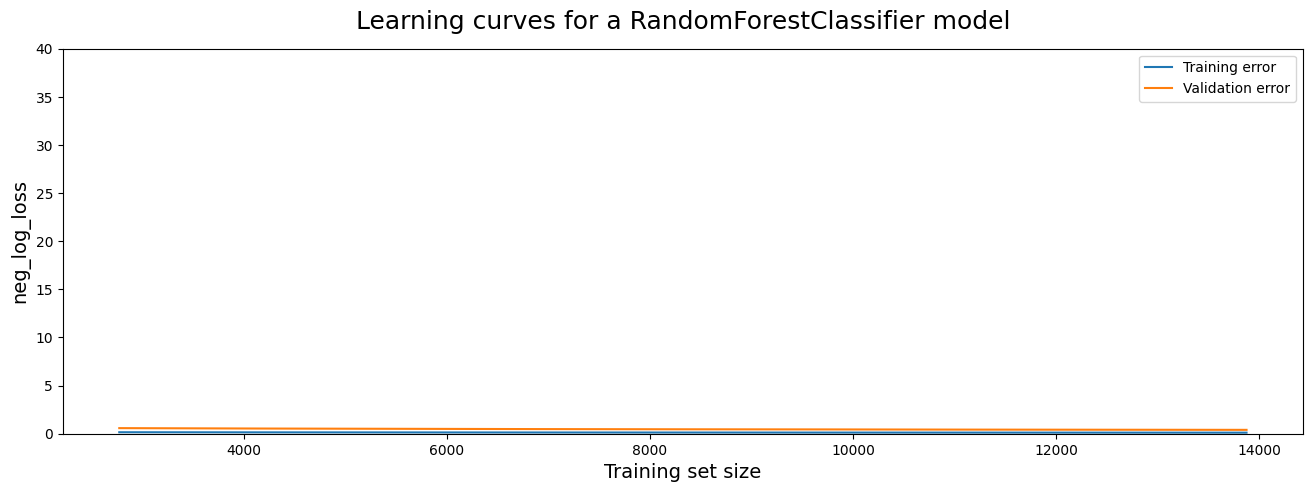

In [60]:

plt.figure(figsize = (16,5))
# plt.subplot(1,2,i)
learning_curves(model, X_train, y_train,[.3,.8,.2,.5,.7,.6,.3,.9,1], 5)

**Process--2 (fit with cross valid)**

In [64]:

K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)

In [ ]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train = np.array(encoded_X_train)
target_train = np.array(y_train)

test = np.array(encoded_X_test)
# target_train = df_train['congestion'].values

test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train)))
for train_index, val_index in tqdm(kf.split(encoded_X_train), total=5):
    train_X, valid_X = train[train_index], train[val_index]
    train_y, valid_y = target_train[train_index], target_train[val_index]
    rf_params = study.best_trial.params
    model = RandomForestClassifier(**rf_params)
    model.fit(train_X, train_y)
    # for train accuracy
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds
    # for test accuracy
    preds = model.predict(test)
    test_preds += (preds)/5
print(np.abs(oof_preds-target_train).mean())

In [67]:
target_test = np.array(y_test)
from sklearn.metrics import accuracy_score
# valid_Acc_SVC=accuracy_score(target_train,oof_preds)
# print(valid_Acc_SVC)

# another technique for calculate test accuracy
test_Acc_SVC=accuracy_score(target_test,test_preds.round())
print(test_Acc_SVC)

0.773474801061008


In [68]:
train_Acc=model.score(encoded_X_train,y_train)
print(train_Acc)

0.9618888376383764


In [69]:
valid_Acc=accuracy_score(target_train,oof_preds)
print(valid_Acc)

0.8124423431734318


In [70]:
# test_accuracy
test_Acc=model.score(encoded_X_test,y_test)
print(test_Acc)

0.8015915119363395


# Evaluation

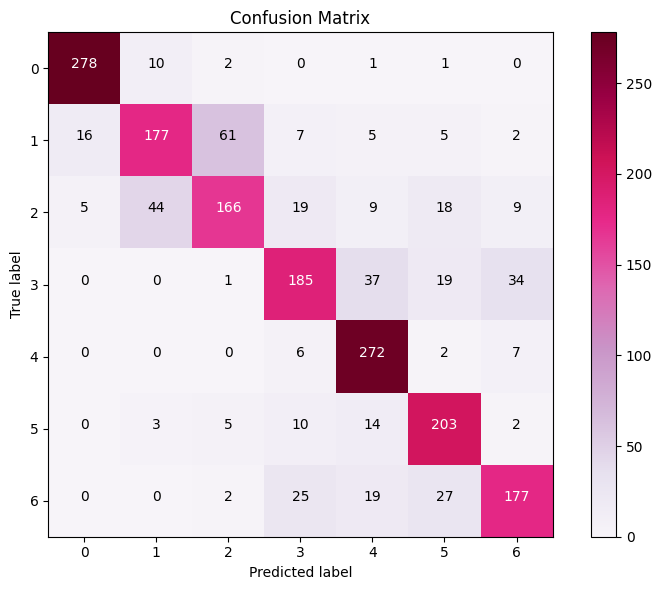

In [72]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()
